John Mount
October 13, 2019

[This](https://github.com/WinVector/data_algebra/blob/master/Examples/WindowFunctions/WindowFunctions.md) is an tutorial on how to use window functions in either the `R` [`rquery`](https://github.com/WinVector/rquery) package, or in the `Python` [`data_algebra`](https://github.com/WinVector/data_algebra) package (`R` example [here](https://github.com/WinVector/rquery/blob/master/Examples/WindowFunctions/WindowFunctions.md), `Python` example [here](https://github.com/WinVector/data_algebra/blob/master/Examples/WindowFunctions/WindowFunctions.md)).


The [data_algebra](https://github.com/WinVector/data_algebra) provides a simplified (though verbose) unified interface to Pandas and SQL data transforms, including windows functions.

Let's work an example. First bring in our packages.

In [1]:
import sqlite3
import pandas
import graphviz

import data_algebra.diagram
from data_algebra.data_ops import *  # https://github.com/WinVector/data_algebra
import data_algebra.util
import data_algebra.SQLite

Now some example data.

In [2]:
d = pandas.DataFrame({
    'g': ['a', 'b', 'b', 'c', 'c', 'c'],
    'x': [1, 4, 5, 7, 8, 9],
    'v': [10, 40, 50, 70, 80, 90],
})

And we can run a number of ordered and un-ordered window functions (the distinction is given by if there is an `order_by` argument present).

In [3]:
table_description = describe_table(d)

ops = table_description. \
    extend({
        'row_number': '_row_number()',
        'shift_v': 'v.shift()',
    },
    order_by=['x'],
    partition_by=['g']). \
    extend({
        'ngroup': '_ngroup()',
        'size': '_size()',
        'max_v': 'v.max()',
        'min_v': 'v.min()',
        'sum_v': 'v.sum()',
        'mean_v': 'v.mean()',
    },
    partition_by=['g'])

res1 = ops.transform(d)

res1

,g,x,v,row_number,shift_v,ngroup,size,max_v,min_v,sum_v,mean_v
0,a,1,10,1,NaN,0,1,10,10,10,10
1,b,4,40,1,NaN,1,2,50,40,90,45
2,b,5,50,2,40.0,1,2,50,40,90,45
3,c,7,70,1,NaN,2,3,90,70,240,80
4,c,8,80,2,70.0,2,3,90,70,240,80
5,c,9,90,3,80.0,2,3,90,70,240,80


One of the benefits of the `data_algebra` is the commands are saved in an object.

In [4]:
print(ops.to_python(pretty=True))

TableDescription(table_name="data_frame", column_names=["g", "x", "v"]).extend(
    {"row_number": "_row_number()", "shift_v": "v.shift()"},
    partition_by=["g"],
    order_by=["x"],
).extend(
    {
        "ngroup": "_ngroup()",
        "size": "_size()",
        "max_v": "v.max()",
        "min_v": "v.min()",
        "sum_v": "v.sum()",
        "mean_v": "v.mean()",
    },
    partition_by=["g"],
)



We can also present a diagram of the operator chain.

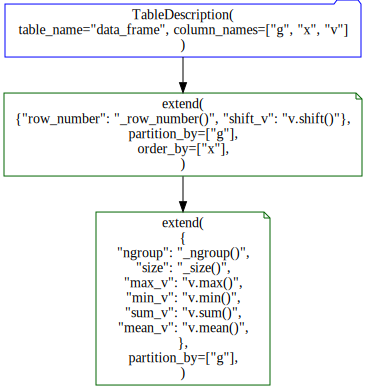

In [5]:
dot_1 = data_algebra.diagram.to_digraph(ops)
dot_1

And these commands can be re-used and even exported to SQL (including large scale SQL such as PostgreSQL, Apache Spark, or Google Big Query).

For a simple demonstration we will use small-scale SQL as realized in SQLite.

In [6]:
conn = sqlite3.connect(":memory:")
db_model = data_algebra.SQLite.SQLiteModel()
db_model.prepare_connection(conn)

ops_db = table_description. \
    extend({
        'row_number': '_row_number()',
        'shift_v': 'v.shift()',
    },
    order_by=['x'],
    partition_by=['g']). \
    extend({
        # 'ngroup': '_ngroup()',
        'size': '_size()',
        'max_v': 'v.max()',
        'min_v': 'v.min()',
        'sum_v': 'v.sum()',
        'mean_v': 'v.mean()',
    },
    partition_by=['g'])

db_model.insert_table(conn, d, table_description.table_name)
sql1 = ops_db.to_sql(db_model, pretty=True)

print(sql1)

SELECT "g",
       "x",
       "v",
       "row_number",
       "shift_v",
       SUM(1) OVER (PARTITION BY "g") AS "size",
                   MAX("v") OVER (PARTITION BY "g") AS "max_v",
                                 MIN("v") OVER (PARTITION BY "g") AS "min_v",
                                               SUM("v") OVER (PARTITION BY "g") AS "sum_v",
                                                             avg("v") OVER (PARTITION BY "g") AS "mean_v"
FROM
  (SELECT "g",
          "x",
          "v",
          ROW_NUMBER() OVER (PARTITION BY "g"
                             ORDER BY "x") AS "row_number",
                            LAG("v") OVER (PARTITION BY "g"
                                           ORDER BY "x") AS "shift_v"
   FROM ("data_frame") "SQ_0") "SQ_1"


And we can execute this SQL either to materialize a remote result (which involves no data motion, as we send the SQL commands to the database, not move the data to/from Python), or to bring a result back from the database to Python.

In [7]:
res1_db = db_model.read_query(conn, sql1)

res1_db

,g,x,v,row_number,shift_v,size,max_v,min_v,sum_v,mean_v
0,a,1,10,1,NaN,1,10,10,10,10.0
1,b,4,40,1,NaN,2,50,40,90,45.0
2,b,5,50,2,40.0,2,50,40,90,45.0
3,c,7,70,1,NaN,3,90,70,240,80.0
4,c,8,80,2,70.0,3,90,70,240,80.0
5,c,9,90,3,80.0,3,90,70,240,80.0


Notice we didn't calculate the group-id `rgroup` in the `SQL` version.  This is because this is a much less common window function (and not often used in applications). This is also only interesting when we are using a composite key (else the single key column is already the per-group id). So not all data_algebra pipelines can run in all environments. However, we can compute (arbitrary) group IDs in a domain independent manner as follows.

In [8]:
id_ops_a = table_description. \
    project(group_by=['g']). \
    extend({
        'ngroup': '_row_number()',
    },
    order_by=['g'])

id_ops_b = table_description. \
    natural_join(id_ops_a, by=['g'], jointype='LEFT')

print(id_ops_b.to_python(pretty=True))

TableDescription(table_name="data_frame", column_names=["g", "x", "v"]).natural_join(
    b=TableDescription(table_name="data_frame", column_names=["g", "x", "v"])
    .project({}, group_by=["g"])
    .extend({"ngroup": "_row_number()"}, order_by=["g"]),
    by=["g"],
    jointype="LEFT",
)



Here we land the result in the database, without moving data through Python.

In [9]:
sql2 = id_ops_b.to_sql(db_model)

cur = conn.cursor()
cur.execute('CREATE TABLE remote_result AS ' + sql2)

And we later copy it over to look at.

In [10]:
res2_db = db_model.read_table(conn, 'remote_result')

res2_db

,g,v,x,ngroup
0,a,10,1,1
1,b,40,4,2
2,b,50,5,2
3,c,70,7,3
4,c,80,8,3
5,c,90,9,3


And we can execute the same pipeline in Pandas.

In [11]:
id_ops_b.transform(d)

,g,x,v,ngroup
0,a,1,10,1
1,b,4,40,2
2,b,5,50,2
3,c,7,70,3
4,c,8,80,3
5,c,9,90,3


And we can diagram the group labeling operation.

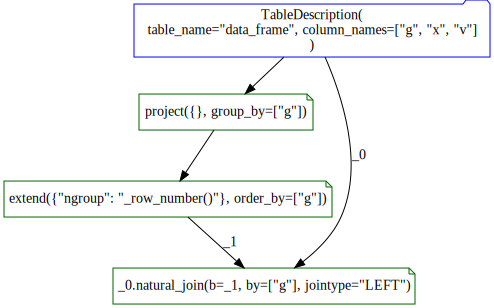

In [12]:
dot_b = data_algebra.diagram.to_digraph(id_ops_b)
dot_b

Or all the steps in one sequence.

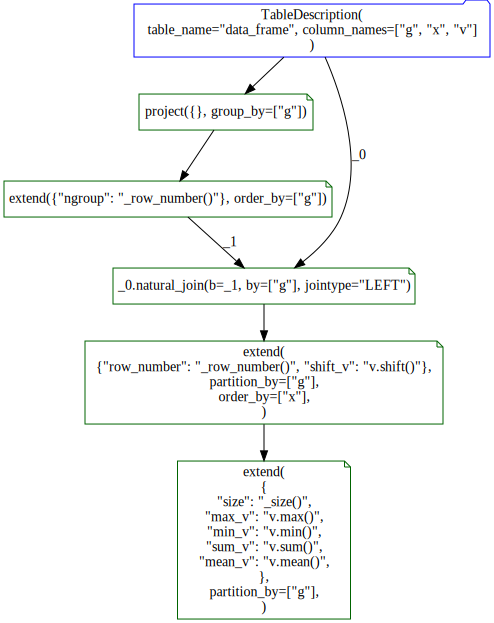

In [13]:
all_ops = id_ops_b. \
    extend({
        'row_number': '_row_number()',
        'shift_v': 'v.shift()',
    },
    order_by=['x'],
    partition_by=['g']). \
    extend({
        'size': '_size()',
        'max_v': 'v.max()',
        'min_v': 'v.min()',
        'sum_v': 'v.sum()',
        'mean_v': 'v.mean()',
    },
    partition_by=['g'])

dot_all = data_algebra.diagram.to_digraph(all_ops)
dot_all

And we can run this whole sequence with Pandas.

In [14]:
all_ops.transform(d)

,g,x,v,ngroup,row_number,shift_v,size,max_v,min_v,sum_v,mean_v
0,a,1,10,1,1,NaN,1,10,10,10,10
1,b,4,40,2,1,NaN,2,50,40,90,45
2,b,5,50,2,2,40.0,2,50,40,90,45
3,c,7,70,3,1,NaN,3,90,70,240,80
4,c,8,80,3,2,70.0,3,90,70,240,80
5,c,9,90,3,3,80.0,3,90,70,240,80


Or in the database (via automatic `SQL` generation).

In [15]:
db_model.read_query(conn, all_ops.to_sql(db_model))

,g,x,v,ngroup,row_number,shift_v,size,max_v,min_v,sum_v,mean_v
0,a,1,10,1,1,NaN,1,10,10,10,10.0
1,b,4,40,2,1,NaN,2,50,40,90,45.0
2,b,5,50,2,2,40.0,2,50,40,90,45.0
3,c,7,70,3,1,NaN,3,90,70,240,80.0
4,c,8,80,3,2,70.0,3,90,70,240,80.0
5,c,9,90,3,3,80.0,3,90,70,240,80.0


In [16]:
# clean up
conn.close()